# Логистическая регрессия для Pima Indians Diabetes

- Описательная статистика (`summary`), создание категориальных факторов;
- Базовая логит-модель (`glm` с биномиальной семьёй), уравнение регрессии;
- Тесты значимости коэффициентов (Wald / z), тест значимости модели (Likelihood Ratio и Wald);
- Доверительные интервалы (confint и вручную), сравнение Logit vs Probit;
- Confusion matrix (порог 0.5), sensitivity / specificity, поиск оптимального порога (Youden index);
- Разбиение на train/test, ROC-кривая и AUC;
- Stepwise selection по AIC.

Датасет: Pima Indians Diabetes (768 наблюдений, y = Outcome (0/1 diabetes), x1 = Pregnancies, x2 = Glucose, x3 = BloodPressure, x4 = SkinThickness, x5 = Insulin, x6 = BMI, x7 = DiabetesPedigreeFunction, x8 = Age).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')

## Загрузка данных и предобработка

In [2]:
pimaDataFrame = pd.read_csv('datasets/pima-indians-diabetes.csv', header=None)
pimaDataFrame.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y']
pimaDataFrame = pimaDataFrame.replace(0, np.nan).fillna(pimaDataFrame.median())
pimaDataFrame['y'] = pimaDataFrame['y'].astype(int)
display(pimaDataFrame.head())

print('Размер данных:', pimaDataFrame.shape)
pimaDataFrame.info()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,6.0,148.0,72.0,35.0,30.5,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,30.5,26.6,0.351,31,0
2,8.0,183.0,64.0,23.0,30.5,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,3.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


Размер данных: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      768 non-null    float64
 1   x2      768 non-null    float64
 2   x3      768 non-null    float64
 3   x4      768 non-null    float64
 4   x5      768 non-null    float64
 5   x6      768 non-null    float64
 6   x7      768 non-null    float64
 7   x8      768 non-null    int64  
 8   y       768 non-null    int32  
dtypes: float64(7), int32(1), int64(1)
memory usage: 51.1 KB


## Описательная статистика

In [3]:
display(pimaDataFrame.describe(include='all'))

print('\nCounts of y:')
print(pimaDataFrame['y'].value_counts())

,x1,x2,x3,x4,x5,x6,x7,x8,y
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.278646,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.021516,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Counts of y:
0    500
1    268
Name: y, dtype: int64


## Создание категориальной переменной

Создадим категориальную переменную на основе x8 (Age), разделив на группы: young (<30), middle (30-50), old (>50).

In [4]:
pimaDataFrame['x8_cat'] = pd.cut(pimaDataFrame['x8'], bins=[0, 30, 50, np.inf], labels=['young', 'middle', 'old'])
pimaDataFrame['x8_cat'] = pimaDataFrame['x8_cat'].astype('category')
print('x8_cat unique categories:', pimaDataFrame['x8_cat'].cat.categories)
display(pimaDataFrame[['x8','x8_cat']].head())

x8_cat unique categories: Index(['young', 'middle', 'old'], dtype='object')


,x8,x8_cat
0,50,middle
1,31,middle
2,32,middle
3,21,young
4,33,middle


## Базовая логит-модель (glm с биномиальной семьёй)

Модель с максимально возможным количеством предикторов (включая категориальные через C()).

In [5]:
predictorTerms = []
for col in ['x1','x2','x3','x4','x5','x6','x7']:
    if col in pimaDataFrame.columns:
        predictorTerms.append(col)
predictorTerms.append('C(x8_cat)')

formula = 'y ~ ' + ' + '.join(predictorTerms)
print('Formula:', formula)

glmLogitModel = smf.glm(formula=formula, data=pimaDataFrame, family=sm.families.Binomial()).fit()
print('--- GLM (Logit) summary ---')
print(glmLogitModel.summary())

Formula: y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + C(x8_cat)
--- GLM (Logit) summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  768
Model:                            GLM   Df Residuals:                      758
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -348.14
Date:                Mon, 08 Dec 2025   Deviance:                       696.28
Time:                        19:31:31   Pearson chi2:                     758.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3209
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

## Уравнение бинарной регрессии (логит)
Запишем в явном виде logit(p) = beta0 + beta1*x1 + ... и покажем коэффициенты.

In [6]:
coefficientsLogit = glmLogitModel.params
print('Coefficients (logit):')
display(coefficientsLogit)

termsLogit = []
for name, coef in coefficientsLogit.items():
    termsLogit.append(f'({coef:.4f})*{name}')
equationLogit = 'logit(p) = ' + ' + '.join(termsLogit)
print('\nRegression equation (logit scale):')
print(equationLogit)

print('\nProbability form: p = 1 / (1 + exp(-linearPredictor))')

Coefficients (logit):


Intercept             -8.754698
C(x8_cat)[T.middle]    0.935306
C(x8_cat)[T.old]       0.462456
x1                     0.094451
x2                     0.038793
x3                    -0.013108
x4                    -0.001654
x5                    -0.001319
x6                     0.095740
x7                     0.813620
dtype: float64


Regression equation (logit scale):
logit(p) = (-8.7547)*Intercept + (0.9353)*C(x8_cat)[T.middle] + (0.4625)*C(x8_cat)[T.old] + (0.0945)*x1 + (0.0388)*x2 + (-0.0131)*x3 + (-0.0017)*x4 + (-0.0013)*x5 + (0.0957)*x6 + (0.8136)*x7

Probability form: p = 1 / (1 + exp(-linearPredictor))


## Тест значимости коэффициентов по отдельности (Wald / z-test)

Для GLM стандартный вывод содержит `z` (Wald) и p-values.

In [7]:
coefEstimate = glmLogitModel.params
coefStdErr = glmLogitModel.bse
zValues = coefEstimate / coefStdErr
pValues = 2 * (1 - sps.norm.cdf(np.abs(zValues)))

resultTable = pd.DataFrame({
    'coef': coefEstimate,
    'stdErr': coefStdErr,
    'z': zValues,
    'pValue': pValues
})
print('Wald z-test for coefficients:')
display(resultTable)

Wald z-test for coefficients:


,coef,stdErr,z,pValue
Intercept,-8.754698,0.819087,-10.688357,0.000000e+00
C(x8_cat)[T.middle],0.935306,0.241827,3.867667,1.098816e-04
C(x8_cat)[T.old],0.462456,0.341256,1.355160,1.753665e-01
x1,0.094451,0.037293,2.532693,1.131900e-02
x2,0.038793,0.003927,9.878312,0.000000e+00
x3,-0.013108,0.008810,-1.487962,1.367609e-01
x4,-0.001654,0.012363,-0.133820,8.935450e-01
x5,-0.001319,0.000934,-1.412143,1.579080e-01
x6,0.095740,0.017973,5.326833,9.993980e-08
x7,0.813620,0.303575,2.680125,7.359477e-03


## Значимость регрессии в целом

Проверим модель в целом двумя способами:
- Wald test; 
- Deviance reduction test;
- Likelihood Ratio Test.

In [ ]:
# Wald test (all coefficients = 0) 
coeffIndex = glmLogitModel.params.index.tolist()
numCoeffs = len(coeffIndex)
allR = np.eye(numCoeffs)
waldResAll = glmLogitModel.wald_test(allR, scalar=True)
statAllRaw = waldResAll.statistic
waldStatAll = float(np.atleast_1d(statAllRaw).squeeze())
dfAll = allR.shape[0]
waldPvalueAll = float(waldResAll.pvalue)
print('Wald test (all coefficients simultaneously):')
print(f'Chi2 stat = {waldStatAll:.6f}, df = {dfAll}, p-value = {waldPvalueAll:.6g}')

# Deviance reduction test
nullDeviance = glmLogitModel.null_deviance
modelDeviance = glmLogitModel.deviance
devianceDiff = nullDeviance - modelDeviance
dfDiff = glmLogitModel.df_model
pValueDeviance = 1 - sps.chi2.cdf(devianceDiff, dfDiff)
print('\nDeviance null =', nullDeviance)
print('Deviance model =', modelDeviance)
print('Deviance reduction =', devianceDiff, ', df =', dfDiff, ', p-value =', pValueDeviance)

# LR test explicitly: compare log-likelihoods with intercept-only model
yVec = pimaDataFrame['y']
XIntercept = sm.add_constant(pd.DataFrame({'const': np.ones(len(pimaDataFrame))}))
nullModel = sm.GLM(yVec, XIntercept, family=sm.families.Binomial()).fit()
llfReduced = nullModel.llf
llfFull = glmLogitModel.llf
lrStat = 2 * (llfFull - llfReduced)
lrDf = glmLogitModel.df_model
lrPvalue = 1 - sps.chi2.cdf(lrStat, lrDf)
print(f'\nLLF full = {llfFull:.6f}')
print(f'LLF null = {llfReduced:.6f}')
print(f'LR stat = {lrStat:.6f}')
print(f'df diff = {dfDiff}')
print(f'LR p-value= {lrPvalue:.6e}')

205.23352578061056
Wald test (all coefficients simultaneously):
Chi2 stat = 205.233526, df = 10, p-value = 1.30575e-38

Deviance null = 993.4839101388137
Deviance model = 696.2817607804028
Deviance reduction = 297.2021493584109 , df = 9 , p-value = 0.0

LLF full = -348.140880
LLF null = -496.741955
LR stat = 297.202149
df diff = 9
LR p-value= 0.000000e+00


## Доверительные интервалы для коэффициентов регрессии

- стандартные (`conf_int`) интервалы из statsmodels;
- построенные вручную как coef ± z*se.

In [9]:
ciWald = glmLogitModel.conf_int(alpha=0.05)
ciWald.columns = ['ciLower','ciUpper']
print('confint (Wald) from model:')
display(ciWald)

ciManualLower = coefEstimate - 1.96 * coefStdErr
ciManualUpper = coefEstimate + 1.96 * coefStdErr
ciManual = pd.DataFrame({'ciManualLower': ciManualLower, 'ciManualUpper': ciManualUpper})
print('\nManual approx (coef ± 1.96*se):')
display(ciManual)

confint (Wald) from model:


,ciLower,ciUpper
Intercept,-10.360079,-7.149316
C(x8_cat)[T.middle],0.461334,1.409277
C(x8_cat)[T.old],-0.206393,1.131305
x1,0.021359,0.167543
x2,0.031096,0.046490
x3,-0.030375,0.004158
x4,-0.025886,0.022577
x5,-0.003149,0.000512
x6,0.060513,0.130967
x7,0.218623,1.408616



Manual approx (coef ± 1.96*se):


,ciManualLower,ciManualUpper
Intercept,-10.360109,-7.149287
C(x8_cat)[T.middle],0.461325,1.409286
C(x8_cat)[T.old],-0.206405,1.131317
x1,0.021357,0.167544
x2,0.031096,0.046490
x3,-0.030375,0.004158
x4,-0.025887,0.022578
x5,-0.003149,0.000512
x6,0.060513,0.130968
x7,0.218612,1.408627


## Сравнение Logit vs Probit

Построим Probit (GLM с link=probit) и сравним AIC / логарифмы правдоподобия.

In [10]:
glmProbitModel = smf.glm(formula=formula, data=pimaDataFrame, family=sm.families.Binomial(link=sm.families.links.Probit())).fit()
print('--- Probit summary ---')
print(glmProbitModel.summary())

print('\nComparison:')
print('Logit AIC =', glmLogitModel.aic, ', Probit AIC =', glmProbitModel.aic)
print('Logit llf =', glmLogitModel.llf, ', Probit llf =', glmProbitModel.llf)

--- Probit summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  768
Model:                            GLM   Df Residuals:                      758
Model Family:                Binomial   Df Model:                            9
Link Function:                 Probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -347.85
Date:                Mon, 08 Dec 2025   Deviance:                       695.69
Time:                        19:31:31   Pearson chi2:                     762.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3214
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept  

## Confusion matrix при пороге 0.5, sensitivity и specificity

In [15]:
def confusionMatrixFromPreds(yTrue, probPred, threshold=0.5):
    yPred = (probPred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(yTrue, yPred).ravel()

    cmDf = pd.DataFrame(
        [[tp, fp],
         [fn, tn]],
        index=['Pred1', 'Pred0'],
        columns=['Actual1', 'Actual0']
    )
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return cmDf, sensitivity, specificity, accuracy

probPredLogit = glmLogitModel.predict(pimaDataFrame)

cm50, sens50, spec50, acc50 = confusionMatrixFromPreds(pimaDataFrame['y'].values, probPredLogit, threshold=0.5)
print('Confusion matrix (threshold=0.5):')
display(cm50)
print('\nSensitivity =', sens50, ', Specificity =', spec50, ', Accuracy =', acc50)

Confusion matrix (threshold=0.5):


,Actual1,Actual0
Pred1,156,57
Pred0,112,443



Sensitivity = 0.582089552238806 , Specificity = 0.886 , Accuracy = 0.7799479166666666


## Поиск оптимального порога (Youden index) и матрица для него

Оптимальный порог — максимизирует (sensitivity + specificity - 1).

In [ ]:
def findOptimalCutoff(yTrue, probPred):
    fpr, tpr, thresholds = roc_curve(yTrue, probPred)
    youdenIndex = tpr - fpr
    bestIdx = np.argmax(youdenIndex)
    bestThreshold = thresholds[bestIdx]
    bestSens = tpr[bestIdx]
    bestSpec = 1 - fpr[bestIdx]

    return bestThreshold, bestSens, bestSpec, bestIdx

bestThr, bestSens, bestSpec, bestIdx = findOptimalCutoff(pimaDataFrame['y'].values, probPredLogit)
print('Optimal threshold (Youden) =', bestThr)
print('Sensitivity =', bestSens, ', Specificity =', bestSpec)

cmOptimal, sensOpt, specOpt, accOpt = confusionMatrixFromPreds(pimaDataFrame['y'].values, probPredLogit, threshold=bestThr)
print('\nConfusion matrix (optimal threshold):')
display(cmOptimal)
print('\nAccuracy =', accOpt)

Optimal threshold (Youden) = 0.23858679236738226
Sensitivity = 0.8768656716417911 , Specificity = 0.6659999999999999

Confusion matrix (optimal threshold):


,Pred0,Pred1
Actual0,333,167
Actual1,33,235



Accuracy = 0.7395833333333334


## Разбиение выборки на train/test и ROC кривая

Если выборка большая, полезно оценивать модель на тестовой выборке. Например с fraction = 0.7.

Train size = 538 , Test size = 230
Test AUC = 0.8457540447648587


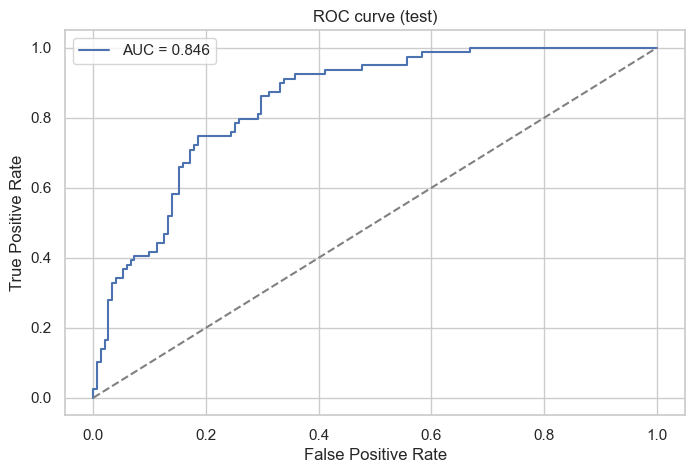

In [ ]:
trainFrac = 0.7
pimaTrain = pimaDataFrame.sample(frac=trainFrac, random_state=42)
pimaTest = pimaDataFrame.drop(pimaTrain.index)
print('Train size =', len(pimaTrain), ', Test size =', len(pimaTest))

glmLogitTrain = smf.glm(formula=formula, data=pimaTrain, family=sm.families.Binomial()).fit()
probPredTest = glmLogitTrain.predict(pimaTest)
fpr, tpr, thresholds = roc_curve(pimaTest['y'], probPredTest)
aucScore = roc_auc_score(pimaTest['y'], probPredTest)
print('Test AUC =', aucScore)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {aucScore:.3f}')
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test)')
plt.legend()
plt.show()

## Stepwise selection по AIC

Реализуем простую stepwise selection для GLM (добавление/удаление по AIC).

In [ ]:
def stepwiseSelectionGLM(dataFrame, response, candidatePredictors, family=sm.families.Binomial(), verbose=True):
    included = []
    while True:
        changed = False
        excluded = [p for p in candidatePredictors if p not in included]
        bestAic = None
        bestToAdd = None

        for newCol in excluded:
            tryPredictors = included + [newCol]
            formulaTry = response + ' ~ ' + ' + '.join(tryPredictors) if tryPredictors else response + ' ~ 1'
            modelTry = smf.glm(formula=formulaTry, data=dataFrame, family=family).fit()
            if bestAic is None or modelTry.aic < bestAic:
                bestAic = modelTry.aic
                bestToAdd = newCol

        if bestToAdd is not None:
            formulaCurrent = response + ' ~ ' + ' + '.join(included) if included else response + ' ~ 1'
            modelCurrent = smf.glm(formula=formulaCurrent, data=dataFrame, family=family).fit()
            if bestAic + 1e-8 < modelCurrent.aic:
                included.append(bestToAdd)
                changed = True
                if verbose:
                    print('Add', bestToAdd, 'AIC=', bestAic)

        if included:
            bestAic = None
            worstToRemove = None

            for col in included:
                tryPredictors = [c for c in included if c != col]
                formulaTry = response + ' ~ ' + ' + '.join(tryPredictors) if tryPredictors else response + ' ~ 1'
                modelTry = smf.glm(formula=formulaTry, data=dataFrame, family=family).fit()
                if bestAic is None or modelTry.aic < bestAic:
                    bestAic = modelTry.aic
                    worstToRemove = col

            modelCurrent = smf.glm(formula=response + ' ~ ' + ' + '.join(included),
                                   data=dataFrame, family=family).fit()
            if bestAic + 1e-8 < modelCurrent.aic:
                included.remove(worstToRemove)
                changed = True
                if verbose:
                    print('Remove', worstToRemove, 'improve AIC to', bestAic)

        if not changed:
            break

    return included


candidatePredictors = []
for term in predictorTerms:
    candidatePredictors.append(term)

selectedPredictors = stepwiseSelectionGLM(
    pimaDataFrame, 'y', candidatePredictors,
    family=sm.families.Binomial(), verbose=True
)

print('\nSelected predictors by stepwise AIC:', selectedPredictors)

Add x2 AIC= 797.6393585318656
Add x6 AIC= 758.2918056127116
Add C(x8_cat) AIC= 722.2395856928445
Add x7 AIC= 718.3956355016496
Add x1 AIC= 714.1213650661323

Selected predictors by stepwise AIC: ['x2', 'x6', 'C(x8_cat)', 'x7', 'x1']


## Если модель улучшилась — повторим диагностику

Если `selectedPredictors` отличается от исходных, подгоняем новую GLM и повторяем выводы.

In [ ]:
if set(selectedPredictors) != set(predictorTerms):
    formulaImproved = 'y ~ ' + ' + '.join(selectedPredictors) if selectedPredictors else 'y ~ 1'
    print('Fitting improved model formula:', formulaImproved)
    glmImproved = smf.glm(formula=formulaImproved, data=pimaDataFrame, family=sm.families.Binomial()).fit()
    print(glmImproved.summary())
else:
    print('Stepwise did not change predictors — оставляем базовую модель.')

Fitting improved model formula: y ~ x2 + x6 + C(x8_cat) + x7 + x1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  768
Model:                            GLM   Df Residuals:                      761
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.06
Date:                Sun, 07 Dec 2025   Deviance:                       700.12
Time:                        18:58:33   Pearson chi2:                     783.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3175
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

## VIF (мультиколлинеарность)

In [ ]:
vifDf = pd.DataFrame()
numericPredictors = [c for c in ['x1','x2','x3','x4','x5','x6','x7'] if c in pimaDataFrame.columns]

dummiesX8 = pd.get_dummies(pimaDataFrame['x8_cat'], prefix='x8')
vifX = pd.concat([pimaDataFrame[numericPredictors].reset_index(drop=True), dummiesX8.reset_index(drop=True)], axis=1)

vifX = vifX.dropna()
vifDf['feature'] = vifX.columns
vifDf['VIF'] = [variance_inflation_factor(vifX.values, i) for i in range(vifX.shape[1])]
display(vifDf)

,feature,VIF
0,x1,1.569016
1,x2,1.314511
2,x3,1.246629
3,x4,1.472297
4,x5,1.251251
5,x6,1.596490
6,x7,1.070329
7,x8_young,29.906154
8,x8_middle,24.282953
9,x8_old,8.467539
